In [ ]:
# %pip install "unstructured[md]" nltk langchain-text-splitters

## **Single Document**

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain.document_loaders import TextLoader

# Load
markdown_path = "./Processed_Files_Introduction_to_End/Copia di iec61158-1{ed1.0}b.md"
loader = TextLoader(markdown_path, autodetect_encoding=True)
doc = loader.load()
doc[0]

In [ ]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]

# MD splits
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=False
)
md_header_splits = markdown_splitter.split_text(doc[0].page_content)
md_header_splits

In [ ]:
# Char-level splits
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Split
splits = text_splitter.split_documents(md_header_splits)
splits

## **All Documents**

In [47]:
import glob
import os
from langchain_core.documents import Document

In [48]:
# 1. Path/pattern for markdown files
folder_path = "./Processed_Files_Introduction_to_End/*.md"

# 2. Parameters for the Header Splitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    strip_headers=False
)

# 3. Parameters for the character-level splitter
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap
)

# Final list for all splits from all files
all_splits = []

for file_path in glob.glob(folder_path):
    # a) Load the file as raw text (preserving Markdown)
    loader = TextLoader(file_path, autodetect_encoding=True)
    docs = loader.load()  # usually returns a list [Document]
    
    # b) For each Document, perform two splits
    for doc in docs:
        md_header_splits = markdown_splitter.split_text(doc.page_content)
        splits = text_splitter.split_documents(md_header_splits)
        
        # c) Use the base file name as "name_file" (without the path and without extension)
        filename = os.path.splitext(os.path.basename(file_path))[0]

        for splitted_doc in splits:
            splitted_doc.metadata["name_file"] = filename
            # Optionally, remove the original "source" if not needed:
            # splitted_doc.metadata.pop("source", None)

        all_splits.extend(splits)

In [ ]:
min_size = 1000  # Minimum size for the merged chunks
merged_documents = []  # List to store merged documents
buffer_content = ""
buffer_metadata = {}

for doc in all_splits:
    text = doc.page_content.strip()  # remove extra spaces if necessary
    # If there is no content accumulated in the buffer and the chunk is small,
    # initialize the buffer with this chunk.
    if not buffer_content and len(text) < min_size:
        buffer_content = text
        buffer_metadata = doc.metadata
    # If there is already content in the buffer, concatenate it with the current chunk.
    elif buffer_content:
        buffer_content += "\n" + text  # add a line break to separate the texts
        # When the buffer reaches or exceeds the minimum size, create a Document
        if len(buffer_content) >= min_size:
            merged_documents.append(
                Document(page_content=buffer_content, metadata=buffer_metadata)
            )
            buffer_content = ""
            buffer_metadata = {}
    # If the current chunk is already large enough and there is nothing in the buffer, add it directly.
    elif len(text) >= min_size:
        merged_documents.append(Document(page_content=text, metadata=doc.metadata))

# If there is remaining content in the buffer, add it as well.
if buffer_content:
    merged_documents.append(Document(page_content=buffer_content, metadata=buffer_metadata))

# Example of printing the results:
for i, document in enumerate(merged_documents):
    print(f"Document {i+1}:")
    print("Metadata:", document.metadata)
    print("Content (first 200 characters):", document.page_content[:200])
    print("-" * 50)

In [ ]:
print(f"Generated {len(all_splits)} chunks in total.")

In [ ]:
print(f"Generated {len(merged_documents)} chunks in total.")

In [ ]:
merged_documents

## **RAG**

In [1]:
from langchain_ollama import OllamaEmbeddings
from langchain.vectorstores import FAISS
from langchain_ollama import ChatOllama
from langchain.schema import Document
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
from typing import List

In [2]:
# Example embeddings (you can use OpenAIEmbeddings or another)
embeddings = OllamaEmbeddings(model="nomic-embed-text:latest")

# Create an in-memory local vector store (FAISS)
# vector_store = FAISS.from_documents(merged_documents, embedding=embeddings)

In [3]:
# vector_store.save_local("faiss_index")

In [4]:
vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [5]:
# Example of an LLM
llm = ChatOllama(temperature=0, model="gemma3:12b")

In [6]:
template = """You are an AI language model assistant that understands PROFIBUS-related documents and specifications in the context of industrial automation.

IMPORTANT: FOCUS **ONLY ON PROFIBUS**.  
DO NOT INCLUDE **ANYTHING** ABOUT PROFINET.  
DO NOT INCLUDE **ANYTHING** ABOUT CANOPEN.  
THIS IS **ONLY** ABOUT PROFIBUS.  
REPEAT: **PROFIBUS ONLY**.  
IGNORE ALL OTHER PROTOCOLS.

### Instructions:
- Answer in a clear, informative, and technically accurate manner.
- Provide a **complete and relevant explanation**, but avoid excessive detail.
- Start with a **direct answer**, then expand with useful clarification, examples, or context if appropriate.
- Avoid unnecessary filler or repetition.
- Answer **in the same language as the question**.
- You can say "I don't know" if you don't know the answer.

### Now answer the following:

Question: {question}

Context: {context}

Answer (in the language of the question):  
"""

prompt = ChatPromptTemplate.from_template(template)

In [7]:
class State(TypedDict):
    question: str           # User's question
    context: List[Document] # Documents returned by the retrieve function
    answer: str             # Final answer from the LLM

def retrieve(state: State):
    """
    Retrieval step: performs a similarity search in the vector_store
    and returns the documents that will serve as context for the answer.
    
    Args:
        state (State): The current state containing the user's question.
    
    Returns:
        dict: A dictionary with the key "context" that will be added to the state.
    """
    retrieved_docs = vector_store.similarity_search(state["question"], k=5)
    # Returns a dictionary with the key "context"
    return {"context": retrieved_docs}

def generate(state: State):
    """
    Generation step: formats the 'context' and the 'question' into a prompt,
    calls the LLM, and obtains the final answer.
    
    Args:
        state (State): The current state containing the user's question and the retrieved context.
    
    Returns:
        dict: A dictionary with the key "answer" containing the final answer from the LLM.
    
    Raises:
        ValueError: If the response format from the LLM is unexpected.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    
    response = llm.invoke(messages)  # or llm(messages), depending on your setup

    # If the response is of type AIMessage and has the attribute 'content', use it:
    if hasattr(response, "content"):
        return {"answer": response.content}
    elif isinstance(response, str):
        return {"answer": response}
    else:
        raise ValueError("Unexpected response format.")

In [8]:
# Build the application graph:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

# Compile into a callable "graph" object
graph = graph_builder.compile()

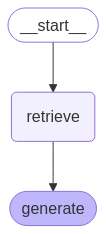

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

## **Queries**

In [ ]:
import re
from pprint import pprint

def clean_answer(answer: str) -> str:
    """
    Cleans the generated answer by removing unnecessary information and formatting.
    
    Args:
        answer (str): The raw answer generated by the LLM.
        
    Returns:
        str: The cleaned answer, formatted for better readability.
    """

    # Remove logs such as INFO:langchain...
    cleaned = re.sub(r'INFO:.*?(\n|$)', '', answer)

    # Extract the value of the 'answer' key if it's a dictionary string
    match = re.search(r"'answer':\s*([\"'])(.*?)\1", cleaned, re.DOTALL)
    if match:
        cleaned = match.group(2)

    # Remove markdown bold formatting **text**
    cleaned = re.sub(r"\*\*(.*?)\*\*", r"\1", cleaned)

    # Remove duplicate spaces and normalize line breaks
    cleaned = re.sub(r'\n{3,}', '\n\n', cleaned)
    cleaned = re.sub(r'[ \t]+$', '', cleaned, flags=re.MULTILINE)

    return cleaned.strip()

def clean_context(context):
    """
    Simplifies the context by extracting relevant metadata and limiting content length.
    
    Args:
        context (List[Document]): The list of documents retrieved as context.
        
    Returns:
        List[dict]: A simplified list of dictionaries containing the document ID and a snippet of the content.
    """
    
    return [
        {
            "id": doc.metadata.get("name_file", doc.metadata.get("source", "unknown")),
            "content": doc.page_content[:300] + "..." if len(doc.page_content) > 300 else doc.page_content
        }
        for doc in context
    ]

def process_question(question: str):
    """
    Process a user's question by retrieving context and generating an answer using the graph.

    Args:
        question (str): The user's question.

    Prints:
        The retrieved context and the generated answer.
    """
    for step_result in graph.stream({"question": question}, stream_mode="updates"):
        if "retrieve" in step_result:
            context = step_result.get("retrieve", {}).get("context", [])
            simplified_context = clean_context(context)
            print("\n📚 Retrieved Context:\n")
            pprint(simplified_context)

        if "generate" in step_result:
            raw_answer = step_result.get("generate", {}).get("answer", "")
            formatted_answer = clean_answer(raw_answer)
            print("\n🧠 Generated Answer:\n")
            print(formatted_answer)


### 1 - What is a GSD file, where can you get it, and what is its function?

In [12]:
question_1 = "What is a GSD file, where can you get it, and what is its function?"
process_question(question_1)


📚 Retrieved Context:

[{'content': '#### **B.4.2.1.1 General**', 'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| Transmission activation    | Activation de transmission  |  \n'
             '<span id="page-190-0"></span>**Figure B.13 – Dispositif de '
             'terrain à isolation galvanique**  \n'
             'En ce qui concerne un dispositif de terrain alimenté par le bus, '
             "l'isolation galvanique doit protéger à la fois les signaux "
             "(c'est-à-dire la tr...",
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '# **B.4.4.3.1 Common description**',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| 4                  | RxD/TxD-P | Receive/transmit data; line B '
             '(red)   |                                              |\n'
             '| 5                  | (Shield)  | Connection to shield not '
             'recommended  |                                              |\n'
             '| Screwed<br>(gland) | Shield    | Shielding            ...'

### 2 - What is a token message and how and which devices use it?

In [13]:
question_2 = "What is a token message and how and which devices use it?"
process_question(question_2)


📚 Retrieved Context:

[{'content': '# INTRODUCTION  \n'
             'This International Standard is one of a series produced to '
             'facilitate the use of communication networks in industrial '
             'control systems.  \n'
             'IEC 61918:2013 provides the common requirements for the '
             'installation of communication networks in industrial control '
             'systems. This installation pr...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '### **C.5.7.3.3 Earthing of equipment (devices)**',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': 'Communication devices, which are used in potentially explosive '
             'areas, shall comply with standards for intrinsically safe '
             'apparatus. The device documentation shall contain a statement '
             'specifying that the devices conform to the FISCO model. Other '
             'specifications which should also be given include permi...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content

### 3 - Which protocol parameter describes the slave's action time after receiving a message?

In [ ]:
question_3 = "Which protocol parameter describes the slave's action time after receiving a message?"
process_question(question_3)


📚 Retrieved Context:

[{'content': '![](_page_190_Figure_2.jpeg)  \n'
             'RxS = received signal TxS = transmitted signal TxA = '
             'Transmission Activation',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **human machine interface**  \n'
             'component of a process control system in use for data '
             'acquisition from an automated process and its appropriate '
             'representation as well as for manipulation of this process',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '![](_page_43_Figure_1.jpeg)  \n'
             '![](_page_43_Figure_2.jpeg)  \n'
             '<span id="page-43-0"></span>**Figure A.12 – Action and '
             'resolution tree for measurement 2 (RS 485 and RS 485-IS)**  \n'
             'e) Measurement 3  \n'
             'This test reveals whether additional terminators are switched on '
             'within the CP 3/1 cable segment. [Figure...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **C.6.3.2.1

### 4 - How to calculate DP cycle time?

In [ ]:
question_4 = "How to calculate DP cycle time?"
process_question(question_4)


📚 Retrieved Context:

[{'content': '| Σ Line length for core cross<br>section q=2,5 mm2 | m  | ≤ 1 '
             '000 | ≤ 1 900 | ≤ 1 200  | ≤ 1 900 | ≤ 1 900 | ≤ 1 900 |  \n'
             'The required current (= Σ current demand) is calculated by the '
             'sum of the basic device currents of the field devices, the '
             'current of the handheld terminal, the current of the cou...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| Diamètre du fil                                            | '
             'n.a.                                                               '
             '|  |\n'
             '| Dispersion du temps de<br>propagation                      | ≤ '
             '20 ns                                                            '
             '|  |',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| Symétrique ou asymétrique                                  | '
             'Symétrique                                          | '
          

### 5 - Briefly explain the function of a watchdog timer in a PROFIBUS DP slave.

In [ ]:
question_5 = "Briefly explain the function of a watchdog timer in a PROFIBUS DP slave."
process_question(question_5)


📚 Retrieved Context:

[{'content': '- [4] PROFIBUS Guideline: *PROFIBUS PA User and Installation '
             'Guideline, V2.2, February 2003. PNO-Order No 2.092*, available '
             'at <http:www.profibus.com> (disponible en anglais seulement)\n'
             '- [5] PROFIBUS Guideline: *PROFIsafe, Additional Requiremenst '
             'for Installation, Immunity and electrical Safety, V1....',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '- [6] PROFIBUS *Guideline: PROFIBUS RS 485-IS User and '
             'Installation Guideline, V1.1, June 2003. PNO-Order No 2.262,* '
             'available at <http:www.profibus.com>\n'
             '- [7] PROFIBUS Guideline: *Installation Guideline for Planning, '
             'V1.0, PNO-Order No 8.012,* available at <http:www.profibus.com>\n'
             '- [8] PROFIBUS Gui...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '# Bibliography  \n'
             '- [1] PROFIBUS Guideline: *Installation Guide for PROFIBUS '
             'D

### 6 - Briefly explain the meaning of “sync” and “freeze” modes. Which device(s) must support these modes?

In [ ]:
question_6 = "Briefly explain the meaning of “sync” and “freeze” modes. Which device(s) must support these modes?"
process_question(question_6)


📚 Retrieved Context:

[{'content': '#### **B.4.4.5.1 Common description**  \n'
             '*Addition:*  \n'
             'If devices according to CP 3/2 with MBP-IS are intended to be '
             'used in hazardous locations then the national regulation shall '
             'be observed when installing such devices.',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| NOTE<br>IEC '
             '61754<br>series<br>defines<br>the<br>optical<br>fibre<br>connector<br>mechanical<br>interfaces;<br>performance '
             '|                                     '
             '|                                  '
             '|                                    '
             '|                                   |                            '
             '...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **B.3.1.85 codage Manchester**  \n'
             'méthode de codage binaire permettant à des récepteurs de '
             'télécommunication série de déterminer, de manière 

### 7 - Discuss the factors that have a significant effect on the overall cycle time of a DP network.

In [ ]:
question_7 = "Discuss the factors that have a significant effect on the overall cycle time of a DP network."
process_question(question_7)


📚 Retrieved Context:

[{'content': '| Wire diameter                             | Application '
             'dependent                                                                     '
             '| Application '
             'dependent                                                                     '
             '|\n'
             '| Delay skew a                              | ≤ 20 ns/100 '
             'm           ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| '
             'influence:                                                                      '
             '| Correlations                                 | '
             'Independent                        | '
             'Independent                      |\n'
             '| Field '
             'assembly:                                                                 '
             '| ++           ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### <span id="page-19-0"></span>**Table A.3 – 

### 8 - What are the four operating modes of a DP class 1 master? Briefly explain the interaction between the master and its assigned slaves in each mode.


In [ ]:
question_8 = "What are the four operating modes of a DP class 1 master? Briefly explain the interaction between the master and its assigned slaves in each mode."
process_question(question_8)


📚 Retrieved Context:

[{'content': '| DCR of shield                             | '
             '-                                                                                         '
             '| '
             '-                                                                                         '
             '|\n'
             '| Number of conductors                      | '
             '4                       ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **human machine interface**  \n'
             'component of a process control system in use for data '
             'acquisition from an automated process and its appropriate '
             'representation as well as for manipulation of this process',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '# **C.1 Installation profile scope**  \n'
             'This standard specifies the installation profile for '
             'Communication Profiles CP 3/3, CP 3/4, CP 3/5, and CP 3/6 '
             '(PROFINET)

### 9 - The data unit of a configuration telegram contains the following 3 bytes represented in hexadecimal notation. Decode the meaning of the bytes. \n- Byte 0:  D1 \n- Byte 1:  23 \n- Byte 2:  70

In [ ]:
question_9 = "The data unit of a configuration telegram contains the following 3 bytes represented in hexadecimal notation. Decode the meaning of the bytes. \n- Byte 0:  D1 \n- Byte 1:  23 \n- Byte 2:  70"
process_question(question_9)


📚 Retrieved Context:

[{'content': '![](_page_167_Figure_1.jpeg)  \n'
             '**Figure B.4 – Modèle de bus de terrain**  \n'
             '<span id="page-167-0"></span>On suppose, pour la modulation, que '
             'chaque station de bus de terrain consomme un courant de base '
             "d'au moins 10 mA et qu'elle est généralement utilisée pour "
             'alimenter le dispositif. Les dispositifs...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **Manchester encoding**  \n'
             'binary encoding method enabling receivers of serial '
             'communications to unambiguously determine the start, end, or '
             'middle of each bit without reference to an external clock '
             '(synchronous)',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **B.3.1.85 codage Manchester**  \n'
             'méthode de codage binaire permettant à des récepteurs de '
             'télécommunication série de déterminer, de manière univoque, le '
     

### 10 - Briefly explain how a slave device, which is in cyclic data exchange, communicates the presence of a diagnostic fault to its controlling master. What does the master do about this?


In [ ]:
question_10 = "Briefly explain how a slave device, which is in cyclic data exchange, communicates the presence of a diagnostic fault to its controlling master. What does the master do about this?"
process_question(question_10)


📚 Retrieved Context:

[{'content': '#### **B.3.1.81 fault disconnect electronic FDE**  \n'
             'equipment used to limit the current consumed by a field device '
             'during a malfunction  \n'
             'Note 1 to entry: This unit can be a part of the field device, or '
             'it can be connected in front of it.',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **A.8 Installation maintenance and installation '
             'troubleshooting**  \n'
             '*Subclause 8.4 has addition:*  \n'
             'In cases of fieldbus network trouble the checklist according to '
             'Annex G of IEC 61918:2013 and the procedures in '
             '[A.6.3.3.1.2](#page-38-0) shall be observed.  \n'
             'Additional troubleshooting means can...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': 'The requirements can be summarised as follows.  \n'
             '- In case of a single fault the current consumption of a device '
             'may exceed 